In [15]:
# 1.3 for estimators
# !conda update tensorflow -y

# 1.4 required for estimator model export that runs on ML Cloud smoothly 
# !pip3 install tensorflow --upgrade --ignore-installed

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
import pandas as pd
print(pd.__version__)

0.19.2


In [19]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.4.1


In [20]:
import numpy as np

from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs

# http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs

# https://www.welt.de/motor/news/article156991316/Unfallstatistik-2015.html
# http://www.openculture.com/2017/12/why-incompetent-people-think-theyre-amazing.html
# 0: young drivers with fast cars: red
# 1: reasonable drivers: green
# 2: a little bit older, more kilometers, general noise: yellow
# 3: really old drivers: red
# 4: young drivers: red
# 5: another green just to have a counter part to all the red ones: green
# 6: people who do not drive a lot: green
# 7: people who drive a lot: yellow
# 8: young people with slow cars: yellow

centers = [(200, 35, 50), (160, 50, 25), (170, 55, 30), (170, 75, 20), (170, 30, 30), (190, 45, 40), (160, 40, 15), (180, 50, 45), (140, 25, 15)]
cluster_std = [4, 9, 18, 8, 9, 5, 8, 12, 5]

X, y = make_blobs(n_samples=1500, n_features=3, centers=centers, random_state=42, cluster_std = cluster_std)

# http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html
# X, y = make_classification(n_features=3, n_redundant=0, n_informative=3,
#                              n_clusters_per_class=2, n_classes=3, random_state=42)

feature_names = ['max speed', 'age' ,'thousand km per year']
df = pd.DataFrame(X, columns=feature_names)
df = df.round()
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.clip.html

df['max speed'] = df['max speed'].clip(90,400)
df['age'] = df['age'].clip(18,90)
df['thousand km per year'] = df['thousand km per year'].clip(5,500)

X = df.as_matrix()

# merges clusters into one group
for group in np.nditer(y, op_flags=['readwrite']):
    if group == 3 or group == 4:
        group[...] = 0
    if group == 5 or group == 6:
        group[...] = 1
    if group == 7 or group == 8:
        group[...] = 2

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [23]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [10]:
# ignore this, it is just technical code
# should come from a lib, consider it to appear magically 
# Adapted from
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#AA4444', '#006000', '#AAAA00'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25

def meshGrid(x_data, y_data):
    h = 1  # step size in the mesh
    x_min, x_max = x_data.min() - 1, x_data.max() + 1
    y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(classifier, x_data, y_data, x_label, y_label, colors, title="", mesh=True):
    xx,yy = meshGrid(x_data, y_data)
    grid_X = np.c_[yy.ravel(), xx.ravel()]
    predict_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": grid_X},
      num_epochs=1,
      shuffle=False)
    predictions = list(classifier.predict(input_fn=predict_input_fn))
    predicted_classes = [p["class_ids"][0] for p in predictions]
    Z = np.array(predicted_classes)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(20,10))
    if mesh:
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.scatter(x_data, y_data, c=colors, cmap=cmap_bold, s=80, marker='o')
    plt.xlabel(x_label, fontsize=font_size)
    plt.ylabel(y_label, fontsize=font_size)
    plt.title(title, fontsize=font_size)

In [11]:
X_train_kmh_age = X_train[:, :2]
X_test_kmh_age = X_test[:, :2]

In [12]:
X_train_2_dim = X_train_kmh_age
X_test_2_dim = X_test_kmh_age

In [13]:
# https://www.tensorflow.org/get_started/estimator

feature_columns = [tf.feature_column.numeric_column("x", shape=[2])]
classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                          hidden_units=[100, 100, 100],
#                                           activation_fn=tf.nn.sigmoid,
                                          activation_fn=tf.nn.relu,
#                                           dropout=.1,
                                          n_classes=3)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
     x={"x": X_train_2_dim},
     y=y_train,
     num_epochs=None,
     shuffle=True)
%time classifier.train(input_fn=train_input_fn, steps=3000)

CPU times: user 16.7 s, sys: 1.12 s, total: 17.9 s
Wall time: 8.27 s


In [14]:
# predict_input_fn = tf.estimator.inputs.numpy_input_fn(
#       x={"x": X_train_2_dim},
#       num_epochs=1,
#       shuffle=False)
# predictions = list(classifier.predict(input_fn=predict_input_fn))
# predicted_classes = np.array([p["class_ids"][0] for p in predictions])
# predicted_classes

In [15]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": X_train_2_dim},
      y=y_train,
      num_epochs=1,
      shuffle=False)
classifier.evaluate(input_fn=train_input_fn)["accuracy"]

0.63666666

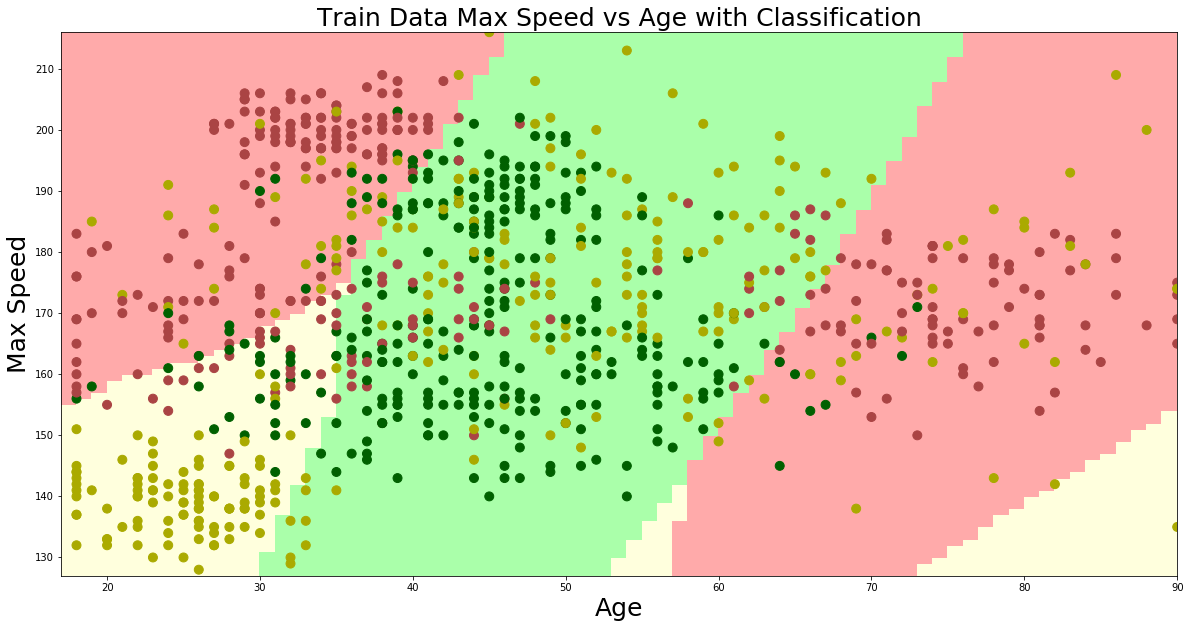

In [16]:
plotPrediction(classifier, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data Max Speed vs Age with Classification")

In [17]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": np.array(X_test_2_dim)},
      y=np.array(y_test),
      num_epochs=1,
      shuffle=False)
classifier.evaluate(input_fn=test_input_fn)["accuracy"]

0.63999999

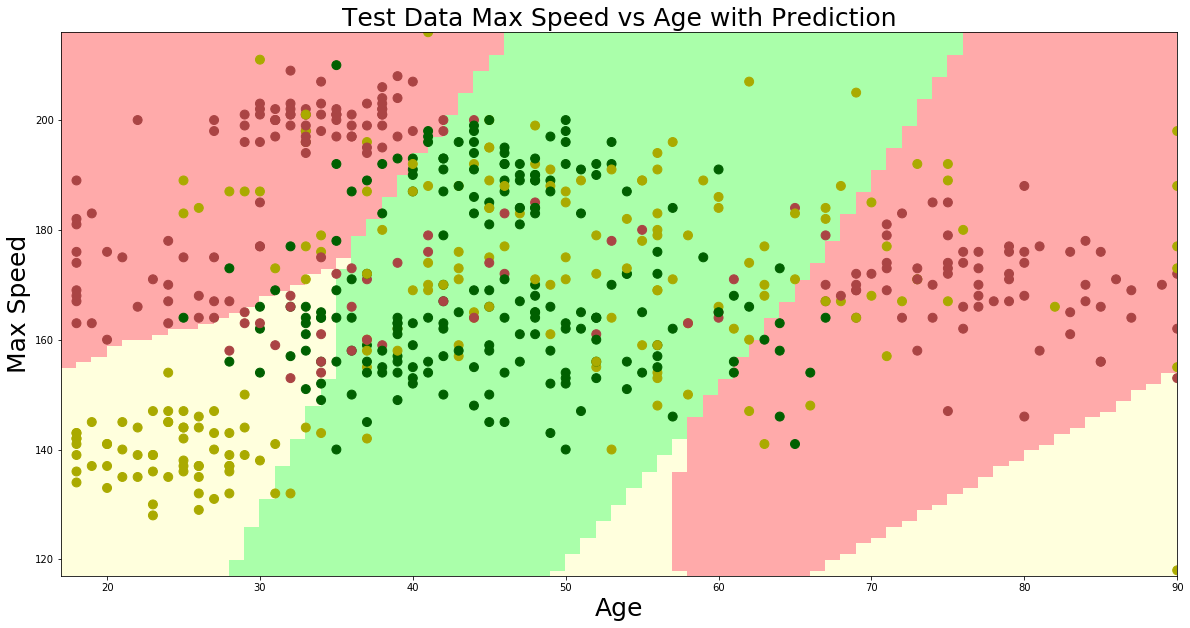

In [18]:
plotPrediction(classifier, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data Max Speed vs Age with Prediction")

In [24]:
feature_columns = [tf.feature_column.numeric_column("x", shape=[3])]
classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                          hidden_units=[100, 100, 100],
#                                           activation_fn=tf.nn.sigmoid,
                                          activation_fn=tf.nn.relu,
#                                           dropout=.1,
                                          n_classes=3)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
     x={"x": X_train},
     y=y_train,
     num_epochs=None,
     shuffle=True)
%time classifier.train(input_fn=train_input_fn, steps=3000)

CPU times: user 14.6 s, sys: 2.69 s, total: 17.3 s
Wall time: 9.16 s


In [25]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": X_train},
      y=y_train,
      num_epochs=1,
      shuffle=False)
classifier.evaluate(input_fn=train_input_fn)["accuracy"]

0.71444446

In [26]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": X_test},
      y=y_test,
      num_epochs=1,
      shuffle=False)
classifier.evaluate(input_fn=test_input_fn)["accuracy"]

0.70999998

In [27]:
# predict_input_fn = tf.estimator.inputs.numpy_input_fn(
#       x={"x": X_train},
#       num_epochs=1,
#       shuffle=False)
# predictions = list(classifier.predict(input_fn=predict_input_fn))
# predicted_classes = np.array([p["class_ids"][0] for p in predictions])
# predicted_classes

In [28]:
# https://cloud.google.com/ml-engine/docs/deploying-models
# https://www.tensorflow.org/programmers_guide/saved_model#using_savedmodel_with_estimators
# https://www.tensorflow.org/api_docs/python/tf/estimator/export/build_parsing_serving_input_receiver_fn
# https://www.tensorflow.org/programmers_guide/saved_model#cli_to_inspect_and_execute_savedmodel

# classifier.export_savedmodel?
# tf.estimator.export.build_parsing_serving_input_receiver_fn?
# tf.estimator.export.build_raw_serving_input_receiver_fn?
# tf.FixedLenFeature?

In [52]:
# needs tensorflow 1.4
# before
# ValueError: Classification input must be a single string Tensor; got {'x': <tf.Tensor 'Placeholder:0' shape=(3,) dtype=float32>}

# def json_serving_input_fn():
#   """Build the serving inputs."""
#   inputs = {
#       'x': tf.placeholder(shape=[3], dtype=tf.float32)
#   }
#   return tf.estimator.export.ServingInputReceiver(inputs, inputs)
# classifier.export_savedmodel('./export', json_serving_input_fn)

# feature_spec = {'x': tf.FixedLenFeature(shape=[3], dtype=tf.float32)}
# serving_input_receiver_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(feature_spec)
# classifier.export_savedmodel('./export', serving_input_receiver_fn)

feature_spec = {'x': tf.placeholder(shape=(1, 3), dtype=tf.float32)}
serving_input_receiver_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(feature_spec)
classifier.export_savedmodel('./export', serving_input_receiver_fn)

b'./export/1513620315'

In [53]:
!ls -lhR tf export

ls: cannot access 'tf': No such file or directory
export:
total 0
drwxr-xr-x 2 nbuser nbuser 0 Dec 18 18:05 1513620315

export/1513620315:
total 0
-rw-r--r-- 1 nbuser nbuser 50K Dec 18 18:05 saved_model.pb
drwxr-xr-x 2 nbuser nbuser   0 Dec 18 18:05 variables

export/1513620315/variables:
total 0
-rw-r--r-- 1 nbuser nbuser 82K Dec 18 18:05 variables.data-00000-of-00001
-rw-r--r-- 1 nbuser nbuser 395 Dec 18 18:05 variables.index


In [54]:
!saved_model_cli show --dir export/1513620315 --tag_set serve

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "predict"


In [55]:
!saved_model_cli show --dir export/1513620315 --tag_set serve --signature_def predict

The given SavedModel SignatureDef contains the following input(s):
inputs['x'] tensor_info:
    dtype: DT_FLOAT
    shape: (-1, 3)
    name: Placeholder_4:0
The given SavedModel SignatureDef contains the following output(s):
outputs['class_ids'] tensor_info:
    dtype: DT_INT64
    shape: (-1, 1)
    name: dnn/head/predictions/ExpandDims:0
outputs['classes'] tensor_info:
    dtype: DT_STRING
    shape: (-1, 1)
    name: dnn/head/predictions/str_classes:0
outputs['logits'] tensor_info:
    dtype: DT_FLOAT
    shape: (-1, 3)
    name: dnn/head/logits:0
outputs['probabilities'] tensor_info:
    dtype: DT_FLOAT
    shape: (-1, 3)
    name: dnn/head/predictions/probabilities:0
Method name is: tensorflow/serving/predict


In [56]:
!saved_model_cli run --dir export/1513620315 --tag_set serve --signature_def predict --input_exprs 'x=[[160.0,46.0,10.0]]'

2017-12-18 18:05:45.238450: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
Result for output key class_ids:
[[1]]
Result for output key classes:
[[b'1']]
Result for output key logits:
[[-1.28412318  1.72984135  0.20202014]]
Result for output key probabilities:
[[ 0.03877771  0.78982419  0.17139815]]


In [1]:
# https://cloud.google.com/ml-engine/docs/deploying-models

# cd export
# gsutil cp -R 1513596711 gs://insurance1
# create model and version at https://console.cloud.google.com/mlengine
# gcloud ml-engine predict --model=insurance_estimator --version=estimator_v1 --json-instances=./sample_insurance_estimator.json
# SCORES
# [0.9954029321670532, 0.004596732556819916, 3.3544753819114703e-07]